In [2]:
# Setup: GPU check and Drive mount
import torch
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

#from google.colab import drive
#drive.mount('/content/drive')

GPU: NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
""" Only for Colab
# Clone repository
# !git clone https://github.com/emanusilva2003/Assignment_2_ComputerVision

import sys
repo_path = '/content/Assignment_2_ComputerVision'
if repo_path not in sys.path:
    sys.path.insert(0, repo_path)
print(f'Repo path: {repo_path}')
"""

In [1]:
# Imports
import os
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from SUIM.Pytorch.models.suim_net import SUIM_Net
from SUIM.Pytorch.utils.data_utils import get_suim_dataloader

In [31]:
# Configuration
BASE = 'VGG'  # 'VGG' or 'RSB'
BATCH_SIZE = 8
NUM_EPOCHS = 90
CURRENT_EPOCH = 0
CHECKPOINT_FLAG = 1  # 1 IF WE WANT TO START FROM A CHECKPOINT
AUGMENTATION_FLAG = 0  # 1 TO USE AUGMENTATION
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Paths (ajusta o caminho do Drive para o teu dataset)
TRAIN_DIR = 'SUIM/train_val'  # '/content/Assignment_2_ComputerVision/SUIM/train_val' COLAB
CKPT_DIR = 'SUIM/Pytorch/ckpt_VGG_Noaug2' # '/content/drive/MyDrive/ckpt' COLAB
os.makedirs(CKPT_DIR, exist_ok=True)

print(f"{BASE} | Batch: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Device: {DEVICE}")

VGG | Batch: 8 | Epochs: 90 | Device: cuda


In [13]:
# Data and Model
train_loader,val_loader = get_suim_dataloader(
    train_dir=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    target_size=(320, 256),
    augmentation=AUGMENTATION_FLAG, # W/ or W/O data augmentation 
    augmentation_params={'rotation_range': 0.2, 'width_shift_range': 0.05,
                        'height_shift_range': 0.05, 'shear_range': 0.05,
                        'zoom_range': 0.05, 'horizontal_flip': True},
    num_workers=2,
    shuffle=True,
    validation=True, # W/ or W/O validation split (if no val delete val_loader)
    val_ratio=0.2
)

model = SUIM_Net(base=BASE, n_classes=5, pretrained=False).to(DEVICE)
total, trainable = model.count_parameters()
print(f"Samples (Train): {len(train_loader.dataset)} | Samples (Validation): {len(val_loader.dataset)} | Params: {total:,}")

Samples (Train): 1220 | Samples (Validation): 305 | Params: 19,297,157


In [32]:
# Training setup
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Load the checkpoint and extract the model's state dictionary
if CHECKPOINT_FLAG:
  checkpoint = torch.load("SUIM/Pytorch/ckpt_VGG_Noaug2/suimnet_vgg_epoch_70.pth")
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  CURRENT_EPOCH = checkpoint['epoch']
  current_history = checkpoint['history']
  history = current_history

  bestmodel = torch.load("SUIM/Pytorch/ckpt_VGG_Noaug2/suimnet_vgg_best.pth")
  best_val_loss = bestmodel['val_loss']
  epochbestloss = bestmodel['epoch']
  print(f"Loaded checkpoint from epoch {CURRENT_EPOCH} | Best Val. loss {best_val_loss:.4f} from epoch {epochbestloss}")
  CURRENT_EPOCH += 1  # Start from the next epoch
else:
  history = {'loss': [], 'lr': [], 'val_loss': []}
  best_val_loss = float('inf')

Loaded checkpoint from epoch 69 | Best Val. loss 0.0624 from epoch 48


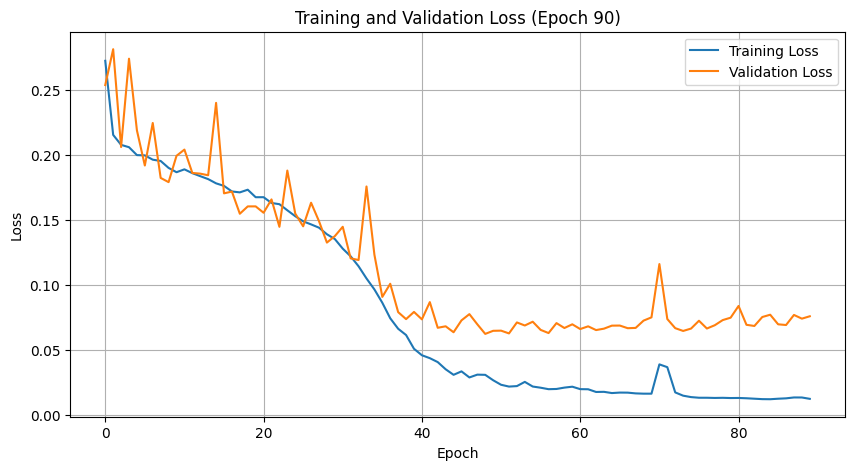

  ✓ Checkpoint saved

Completed! Best validation loss: 0.0624


In [33]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

best_loss = float('inf')

for epoch in tqdm(range(CURRENT_EPOCH, NUM_EPOCHS)):
    model.train()
    epoch_train_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Train)")
    for images, masks in pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_train_loss = epoch_train_loss / len(train_loader)
    history['loss'].append(avg_train_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    # Validation phase
    model.eval()
    epoch_val_loss = 0.0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Validation)")
        for images, masks in val_pbar:
            images, masks = images.to(DEVICE), masks.to(DEVICE)
            outputs = model(images)
            val_loss = criterion(outputs, masks)
            epoch_val_loss += val_loss.item()
            val_pbar.set_postfix({'val_loss': f'{val_loss.item():.4f}'})

    avg_val_loss = epoch_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {history['lr'][-1]:.2e}")
    #scheduler.step(avg_val_loss) # Consider using validation loss for scheduler

    # Dynamic plotting
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss (Epoch {epoch+1})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_train_loss,
            'val_loss': best_val_loss,
            'history': history
        }, os.path.join(CKPT_DIR, f"suimnet_{BASE.lower()}_best.pth"))
        print(f"  ✓ Best Validation Loss: {best_val_loss:.4f}")

    # Checkpoint every 2 epochs
    if (epoch + 1) % 2 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'history': history
        }, os.path.join(CKPT_DIR, f"suimnet_{BASE.lower()}_epoch_{epoch+1}.pth"))
        print(f"  ✓ Checkpoint saved")

print(f"\nCompleted! Best validation loss: {best_val_loss:.4f}")

ANTIGO

In [ ]:
# Training loop
history = {'loss': [], 'lr': []}
best_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, masks in pbar:
        images, masks = images.to(DEVICE), masks.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = epoch_loss / len(train_loader)
    history['loss'].append(avg_loss)
    history['lr'].append(optimizer.param_groups[0]['lr'])
    
    print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} | LR: {history['lr'][-1]:.2e}")
    scheduler.step(avg_loss)
    
    # Save best
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, os.path.join(CKPT_DIR, f"suimnet_{BASE.lower()}_best.pth"))
        print(f"  ✓ Best: {best_loss:.4f}")
    
    # Checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss,
        }, os.path.join(CKPT_DIR, f"suimnet_{BASE.lower()}_epoch_{epoch+1}.pth"))
        print(f"  ✓ Checkpoint saved")

print(f"\nCompleted! Best loss: {best_loss:.4f}")

In [ ]:
# Plot results
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history['loss'], 'b-', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.grid(alpha=0.3)

ax2.plot(history['lr'], 'r-', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')
ax2.set_title('LR Schedule')
ax2.set_yscale('log')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Initial: {history['loss'][0]:.4f} | Final: {history['loss'][-1]:.4f} | Best: {best_loss:.4f}")